Tyler Guldberg
# Real or Render?

My first attempt at this is going to be mounting a couple Google Drive folders to CoLab, and then follow (essentially verbatim) what we did for the flower identifier, then modify it from there to fine tune results.


In [2]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

Mounted at /content/drive
Found 500 real images
Found 500 fake images


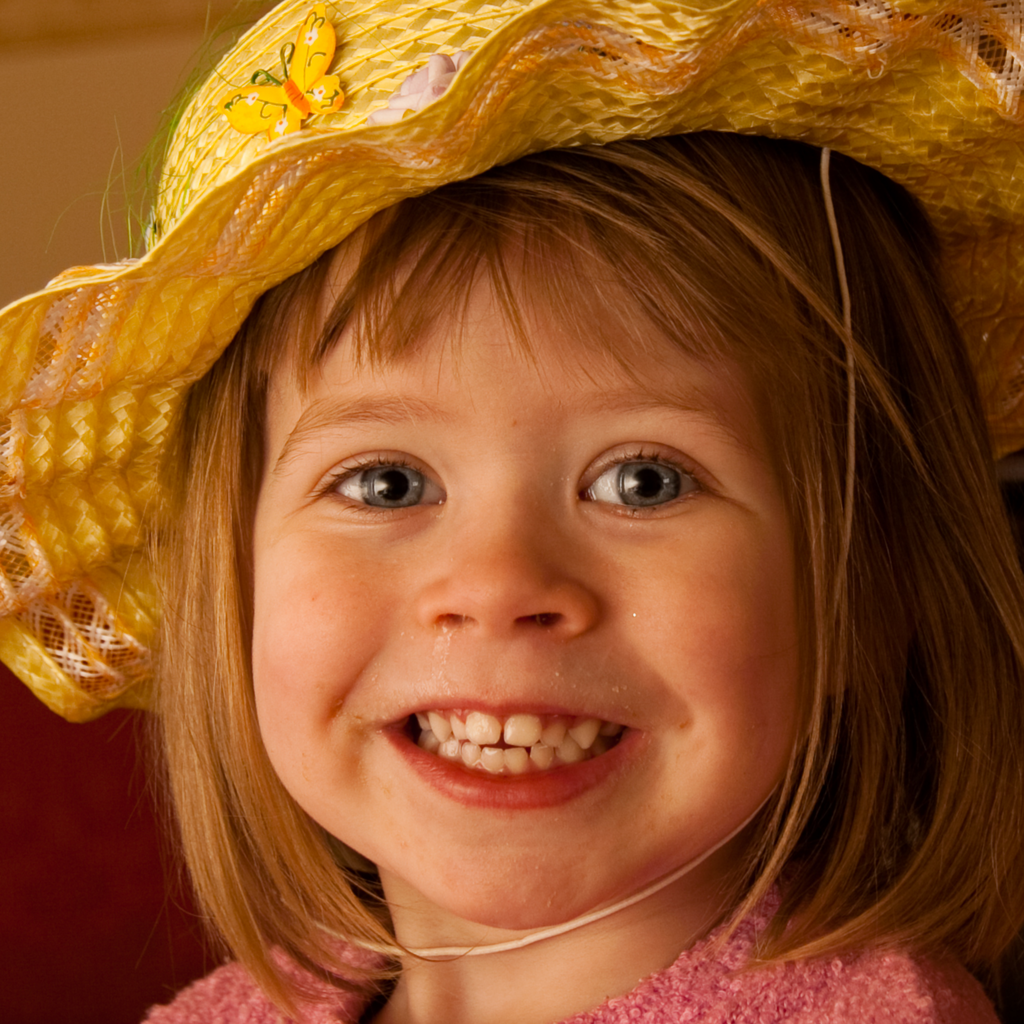

In [3]:
from google.colab import drive
import os
import glob

# 1. Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# 2. Define paths to both datasets
base_path = '/content/drive/MyDrive/RealOrRender'
reals_path = os.path.join(base_path, 'reals')
fakes_path = os.path.join(base_path, 'fakes')

# 3. List all image files
real_images = glob.glob(os.path.join(reals_path, '*.png'))
fake_images = glob.glob(os.path.join(fakes_path, '*.jpg'))

print(f"Found {len(real_images)} real images")
print(f"Found {len(fake_images)} fake images")

# 4. Show first image of reals
from PIL import Image
Image.open(str(real_images[0]))


With the datasets being accessible, I am now going to follow the flower identifier.

Directly below is splitting the data into training data and validation data.

In [4]:
batch_size = 32
img_height, img_width = 256, 256 # sizing them down so colab can handle them (orig 1024x1024)
train = tf.keras.utils.image_dataset_from_directory(base_path,
                                                    validation_split=0.2,
                                                    seed=123,
                                                    subset='training',
                                                    image_size=(img_height, img_width),
                                                    batch_size=batch_size)

Found 1000 files belonging to 2 classes.
Using 800 files for training.


In [5]:
val = tf.keras.utils.image_dataset_from_directory(base_path,
                                                    validation_split=0.2,
                                                    seed=123,
                                                    subset='validation',
                                                    image_size=(img_height, img_width),
                                                    batch_size=batch_size)

Found 1000 files belonging to 2 classes.
Using 200 files for validation.


In [6]:
class_names = train.class_names
train.class_names

['fakes', 'reals']

This is just to get a sampling of each category of data.

In [18]:
import matplotlib.pyplot as plt

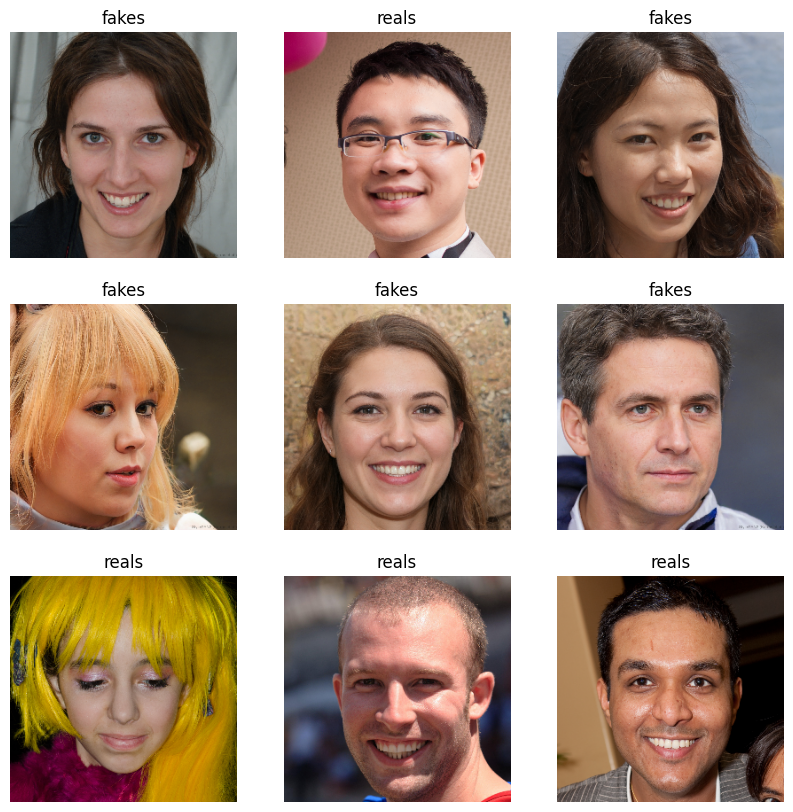

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    ax.imshow(images[i].numpy().astype('uint8'))
    plt.title(train.class_names[labels[i]])
    plt.axis('off')

The code below shuffles the training data, makes and compiles the model, and then trains the model over 15 epochs.

In [7]:
train = train.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

This is the same model that we initially used for the flower identification, though I changed my `input_shape` to by 256 x 256. Training on the full image up 1024 x 1024 takes of ***way*** too much memory. Thus, making it smaller will use vastly less memory.

In [8]:
model = Sequential([
    layers.Rescaling(1/255, input_shape=(256, 256, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(2)
])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,292,130 (16.37 MB)

 Trainable params: 4,292,130 (16.37 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [1]:
epochs = 15
history = model.fit(train, validation_data=val, epochs=epochs)

NameError: name 'model' is not defined

Traning completed! Let's see the graph...

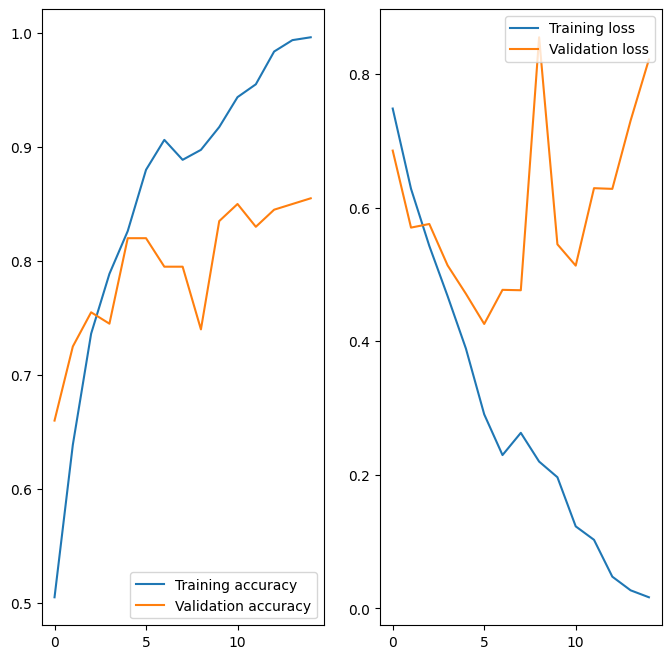

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
e = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(e, acc, label='Training accuracy')
plt.plot(e, val_acc, label='Validation accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(e, loss, label='Training loss')
plt.plot(e, val_loss, label='Validation loss')
plt.legend(loc='upper right')
plt.show()

So, it doesn't totally suck, but it can absolutely be better.

Since the training loss is always decreasing but the validaiton loss is increasing, it is safe to assume that the model is overfitting. We solved this with a dropout layer, and I decided to add one after every layer. I also bumped it down to only 10 epochs instead of 15 since after 10 is when it went pretty off the rails. Lets try it!

In [10]:
model = Sequential([
    layers.Rescaling(1/255, input_shape=(256, 256, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(2)
])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 256, 256, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,292,130 (16.37 MB)

 Trainable params: 4,292,130 (16.37 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs = 10
history = model.fit(train, validation_data=val, epochs=epochs)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 473ms/step - accuracy: 0.5566 - loss: 1.4363 - val_accuracy: 0.4350 - val_loss: 0.6931
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 234ms/step - accuracy: 0.5454 - loss: 0.6882 - val_accuracy: 0.5850 - val_loss: 0.6901
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 284ms/step - accuracy: 0.6123 - loss: 0.6589 - val_accuracy: 0.5500 - val_loss: 0.6703
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 467ms/step - accuracy: 0.6422 - loss: 0.6234 - val_accuracy: 0.6950 - val_loss: 0.6197
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 230ms/step - accuracy: 0.7450 - loss: 0.5230 - val_accuracy: 0.6700 - val_loss: 0.6318
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 237ms/step - accuracy: 0.7846 - loss: 0.5114 - val_accuracy: 0.7150 - val_loss: 0.5419
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 230ms/step - accuracy: 0.8002 - loss: 0.4177 - val_accuracy: 0.7300 - val_loss: 0.5279
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 256ms/step - accuracy: 0.8345 - loss: 0.3670 - val_accurac

Training completed, let's see the graph this time...

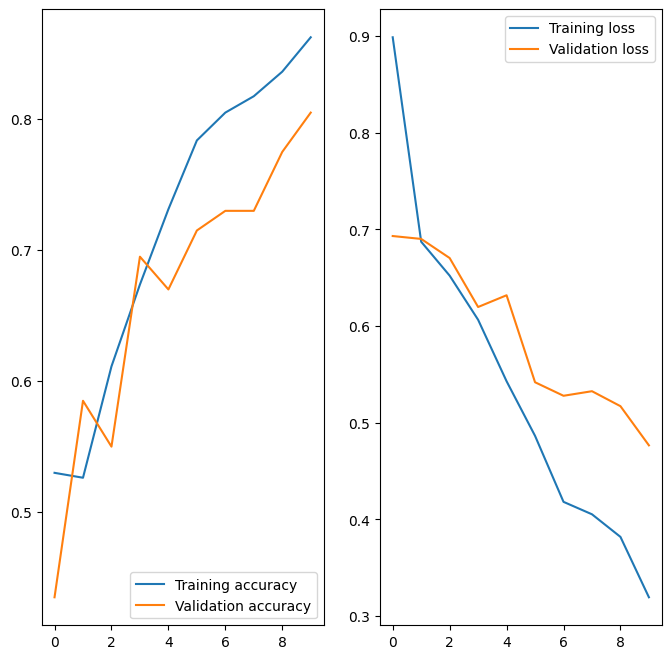

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
e = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(e, acc, label='Training accuracy')
plt.plot(e, val_acc, label='Validation accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(e, loss, label='Training loss')
plt.plot(e, val_loss, label='Validation loss')
plt.legend(loc='upper right')
plt.show()

Not bad! Though I can probably make this even better by increasing my dataset, again very similar to the flower example. We make a new layer in the model with a random rotation, zoom, and horizontal flip.

In [20]:
randomly_changed_data = tf.keras.Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

Then we add the `randomly_changed_data` layer to the model at the top. Then run the model again!

In [43]:
model = Sequential([
    randomly_changed_data,
    layers.Rescaling(1/255, input_shape=(256, 256, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(2)
])
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_9 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 256, 256, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,292,130 (16.37 MB)

 Trainable params: 4,292,130 (16.37 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [45]:
epochs = 10
history = model.fit(train, validation_data=val, epochs=epochs)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 320ms/step - accuracy: 0.4697 - loss: 1.0673 - val_accuracy: 0.4350 - val_loss: 0.6939
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 250ms/step - accuracy: 0.5292 - loss: 0.6872 - val_accuracy: 0.4350 - val_loss: 0.8595
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 247ms/step - accuracy: 0.5637 - loss: 0.6407 - val_accuracy: 0.6900 - val_loss: 0.6304
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 315ms/step - accuracy: 0.7240 - loss: 0.5969 - val_accuracy: 0.7450 - val_loss: 0.5887
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 247ms/step - accuracy: 0.7313 - loss: 0.5615 - val_accuracy: 0.7450 - val_loss: 0.6211
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 318ms/step - accuracy: 0.7296 - loss: 0.5268 - val_accuracy: 0.7550 - val_loss: 0.5450
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 271ms/step - accuracy: 0.7351 - loss: 0.5239 - val_accuracy: 0.7600 - val_loss: 0.4884
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 293ms/step - accuracy: 0.7901 - loss: 0.4586 - val_accuracy: 

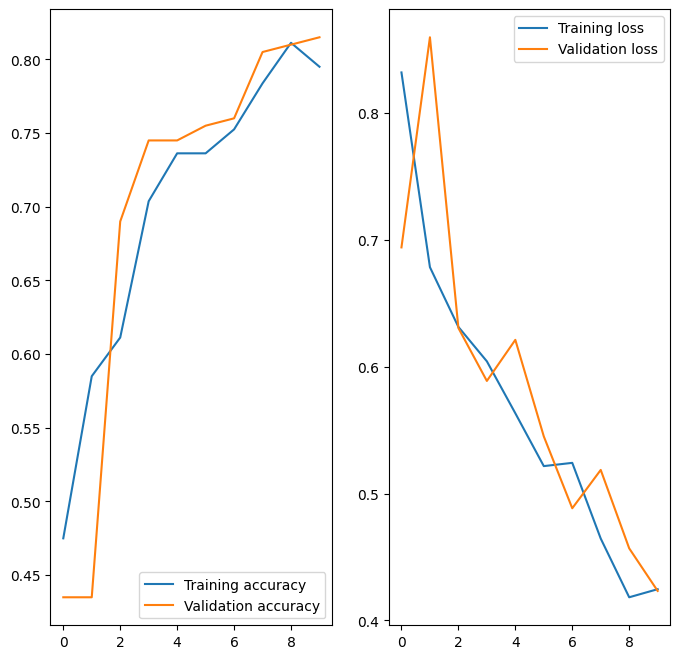

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
e = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(e, acc, label='Training accuracy')
plt.plot(e, val_acc, label='Validation accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(e, loss, label='Training loss')
plt.plot(e, val_loss, label='Validation loss')
plt.legend(loc='upper right')
plt.show()

Ladies and gentlemen, we did it. It seems making sure that I had some randomness to the data (and in turn increasing the dataset size).

Now I'm going to use the website that I used to grab the fake images to grab a brand new image and make the model predict it.

In [49]:
url = "https://thispersondoesnotexist.com/"
img = tf.keras.utils.get_file("fake_img", origin=url)
img = tf.keras.utils.load_img(img, target_size=(img_height, img_width))
img = tf.keras.utils.img_to_array(img)
img = tf.expand_dims(img, 0)

In [50]:
predictions = model.predict(img)
score = tf.nn.softmax(predictions[0])
score

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.77234155, 0.2276584 ], dtype=float32)>

Roughly 70% confident that it is fake! And below is the `class_names` just to show that it ***is*** classifying it as `fakes`.

In [51]:
class_names

['fakes', 'reals']